##### Copyright 2019 The TensorFlow Authors.

# LeNet-5 CNN (Convolution Neural Network)
- Python Keras 로 구현 

### 텐서플로 임포트하기

In [93]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### CIFAR 데이터셋 다운로드하고 준비하기

CIFAR10 데이터세트에는 10개 클래스에 60,000개의 컬러 이미지가 포함되어 있으며 각 클래스에는 6,000개의 이미지가 있습니다. 이 데이터세트는 50,000개의 훈련 이미지와 10,000개의 테스트 이미지로 나뉩니다. 클래스는 상호 배타적이며 서로 겹치지 않습니다.

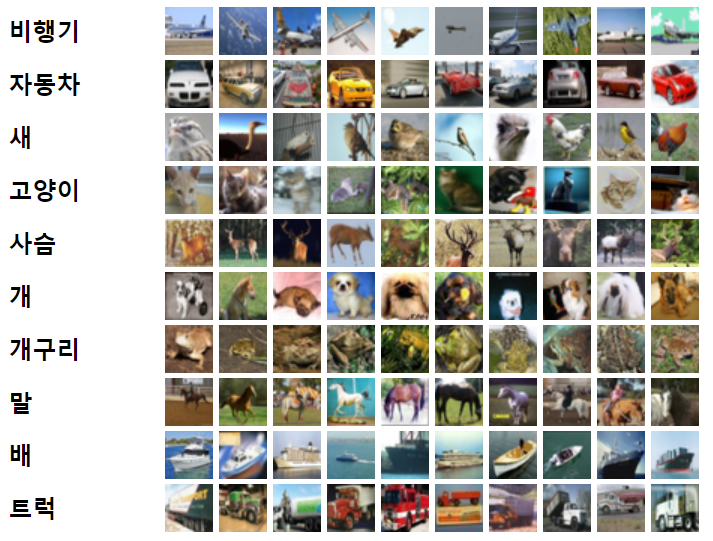

In [94]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

print ("Training data:")
print ("Number of examples: ", X_train.shape[0])
print ("Number of channels:",X_train.shape[3]) 
print ("Image size:", X_train.shape[1], X_train.shape[2])

print ("Test data:")
print ("Number of examples:", X_test.shape[0])
print ("Number of channels:", X_test.shape[3])
print ("Image size:", X_test.shape[1], X_test.shape[2]) 


Training data:
Number of examples:  50000
Number of channels: 3
Image size: 32 32
Test data:
Number of examples: 10000
Number of channels: 3
Image size: 32 32


### 데이터 확인하기

데이터세트가 올바른지 확인하기 위해 훈련 세트의 처음 25개 이미지를 플로팅하고 각 이미지 아래에 클래스 이름을 표시해 보겠습니다.


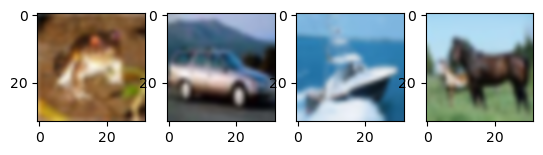

In [95]:
plt.subplot(141)
plt.imshow(X_train[0], interpolation="bicubic")
plt.grid(False)
plt.subplot(142)
plt.imshow(X_train[4], interpolation="bicubic")
plt.grid(False)
plt.subplot(143)
plt.imshow(X_train[8], interpolation="bicubic")
plt.grid(False)
plt.subplot(144)
plt.imshow(X_train[12], interpolation="bicubic")
plt.grid(False)
plt.show()

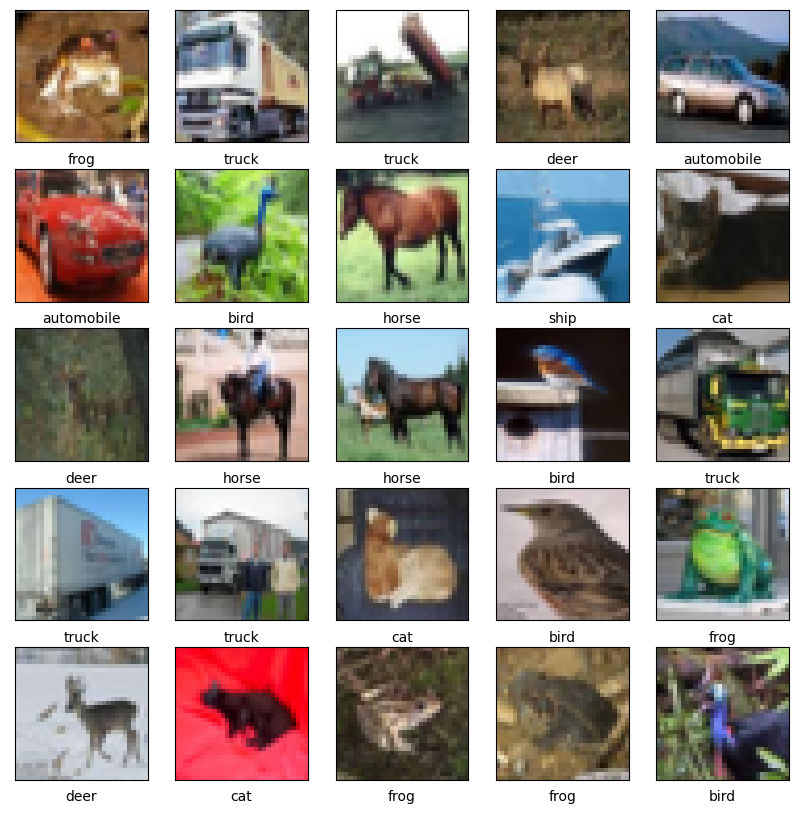

In [96]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

### Preprocessing
- LeNet-1 모델은 28x28의 이미지를 사용
- LeNet-5에서는 MNIST의 28x28 테스트 영상을 32x32 이미지의 중심에 배치하여 처리
    - Zero - Padding을 적용하여 32x32가 되고, 네트워크에 주입되기 전 정규화된다. 
        - 큰사이즈의 이미지 사용으로 인해 작은부분의 고려가 작은사이즈 보다 훨씬 더 고려되어 성능이 더욱 향상되었습니다.
        
-> CIFAR10 의 경우 이미 32x32 shape의 데이터셋.. ! 

### 데이터 정규화

- Normalize pixel values to be between 0 and 1    
머신러닝에서의 핵심중 하나는 cost를 구하고 Gradient Descent와 같은 알고리즘을 사용하여 cost를 최소화 시키는 것    
그렇게 하기 위해 적당한 Learning Rate값을 찾는 것이 중요    

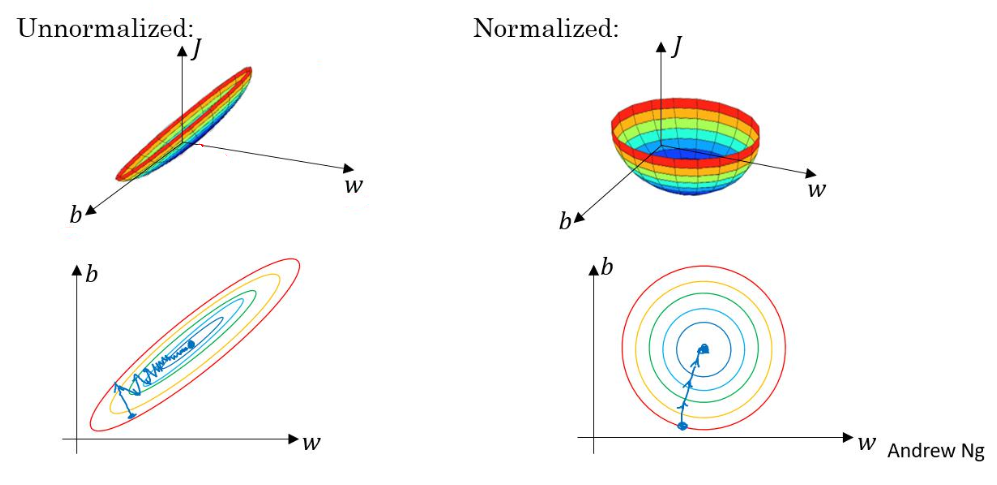

#### Learning Rate와 데이터에 대한 정규화의 상관성 
- 정규화되지 않은 데이터셋은 타원모양
    - Learning Rate를 매우 적게 설정해야 학습이 된다 .
    - 충분하게 작게 설정하지 않을 경우 수평 이동과 수직 이동 시 불균형이 발생하고, Gradient Descent 알고리즘을 적용하기 어려워진다. 
       
- 정규화된 데이터셋은 원 모양
    - Gradient Descent 알고리즘을 적용했을 때, 쉽고 빠르게 최적화 지점을 찾아내려간다. 
    
-> 이러한 이유들 때문에 데이터의 정규화 작업은 필수적.

In [97]:
# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

### LeNet-5 모델 구축

아래 코드에서 [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)와 [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) 층을 쌓는 일반적인 패턴으로 LeNet-5 모델을 정의합니다.

입력으로 CNN은 배치 크기를 무시하고 형상(image_height, image_width, color_channels)의 텐서를 사용합니다. 이러한 차원을 처음 접하는 경우 color_channels는 (R,G,B)를 나타냅니다. 이 예에서는 CIFAR 이미지 형식인 형상(32, 32, 3)의 입력을 처리하도록 CNN을 구성합니다. `input_shape` 인수를 첫 번째 레이어에 전달하여 이를 수행할 수 있습니다.


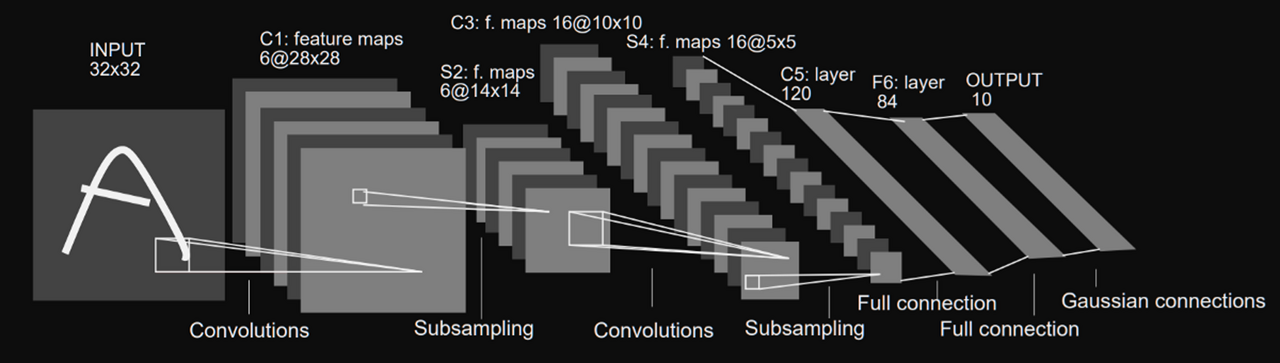

LeNet-5는 입력층을 제외하고 3개의 Convolutional Layer(Cx), 2개의 Sub-Sampling Layer(Sx), 그리고 2개의 Full-Connected Layer(Fx)로 총 7개의 층으로 구성되어 있다.

그래서 [그림 1]에서 C1 - S2 - C3 - S4 - C5 - F6 - OUTPUT(F7)와 같이 층이 쌓이는 순서대로 표현한 걸 볼 수 있다.

Sub-Sampling Layer는 Pooling Layer라고도 하는데 이미지 크기를 줄여 파라미터 수를 감소시키기 위해 사용되며, 논문에서는 Max와 Avg 중 AvgPooling을 사용했다.

여기서 C5 Layer를 그림만 보고 FC(Full-Connected) Layer로 잘못 이해하는 사람이 많은 것 같은데 논문에서도 직접 C5는 Convolution Layer라고 언급했으며, C5는 S4의 OUTPUT인 5x5 이미지를 입력으로 받아 5x5 필터로 합성곱 연산을 수행해 (batch size, 1, 1, filter size)의 크기를 같는다. (*tensorflow 표현 기준)

Yann Lecun는 학습할 때 손실 함수(Loss function)로 MSE(Mean Squared Error)를 채택했지만, Cross Entropy 기법이 훨씬 좋기 때문에 코드에서는 후자를 채택했다.

그리고 OUTPUT에서는 보통 많이 사용하는 SoftMax가 아닌 Euclidean Radial Basis Function을 사용한다고 한다.

In [98]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense

class LeNet5():
    def build(input_shape, classes):
        model = models.Sequential([
            # Convolution Layer  
            Conv2D(filters = 6 , kernel_size = (5, 5), 
                    strides = 1, activation = 'tanh' ,
                    input_shape = input_shape),
            # Avg Pooling Layer 
            # 입력의 평균을 계산 -> 그 값에 학습되는 계숫값을 곱하고 편향을 더함 
            # + 활성화함수 적용 
            AvgPool2D(pool_size=(2, 2), strides=2),
            
            Conv2D(filters=16, kernel_size=(5,5), strides=1, activation='tanh'),
            
            AvgPool2D(pool_size=(2, 2), strides=2),
            
            Conv2D(filters=120, kernel_size=(5,5), strides=1, activation='tanh'),
            
            # Fully Connected Layer 
            Flatten(),
            
            Dense(84, activation='tanh'),
            
            Dense(10, activation='softmax')
            
            ])
        
        model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
        return model

In [99]:
model = LeNet5.build(input_shape = (32, 32, 3), classes = 10)

지금까지 모델의 아키텍처를 표시해 보겠습니다.

In [100]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d_14 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_22 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_15 (Avera  (None, 5, 5, 16)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_23 (Conv2D)          (None, 1, 1, 120)         48120     
                                                                 
 flatten_7 (Flatten)         (None, 120)              

위에서 Conv2D와 MaxPooling2D 층의 출력은 (높이, 너비, 채널) 크기의 3D 텐서입니다. 높이와 너비 차원은 네트워크가 깊어질수록 감소하는 경향을 가집니다. Conv2D 층에서 출력 채널의 수는 첫 번째 매개변수에 의해 결정됩니다(예를 들면, 32 또는 64). 일반적으로 높이와 너비가 줄어듦에 따라 (계산 비용 측면에서) Conv2D 층의 출력 채널을 늘릴 수 있습니다.

##### 마지막에 Dense 층 추가하기

모델을 완성하려면 마지막 합성곱 층의 출력 텐서(크기 (4, 4, 64))를 하나 이상의 Dense 층에 주입하여 분류를 수행합니다. Dense 층은 벡터(1D)를 입력으로 받는데 현재 출력은 3D 텐서입니다. 먼저 3D 출력을 1D로 펼치겠습니다. 그다음 하나 이상의 Dense 층을 그 위에 추가하겠습니다. MNIST 데이터는 10개의 클래스가 있으므로 마지막에 Dense 층에 10개의 출력과 소프트맥스 활성화 함수를 사용합니다.

다음은 모델의 전체 아키텍처입니다.

### 모델 컴파일과 훈련하기

In [101]:
print(X_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


In [112]:
print(X_test.shape, y_test.shape)

(10000, 32, 32, 3) (10000, 1)


In [103]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks_list = [
    ReduceLROnPlateau(
        monitor = 'val_loss', 
        #학습률을 절반으로 줄입니다.
        factor = 0.5, 
        #min Reduces learning
        min_lr=0.00001,
        verbose=1,
        mode='min'
    )]

In [109]:
history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=30, 
                    callbacks=callbacks_list,verbose = 1,validation_split=0.15 )

Epoch 1/30
665/665 [==============================] - 32s 47ms/step - loss: 1.4186 - accuracy: 0.5005 - val_loss: 1.4215 - val_accuracy: 0.4965 - lr: 0.0010
Epoch 2/30
665/665 [==============================] - 26s 39ms/step - loss: 1.3610 - accuracy: 0.5190 - val_loss: 1.3827 - val_accuracy: 0.5130 - lr: 0.0010
Epoch 3/30
665/665 [==============================] - 24s 36ms/step - loss: 1.3046 - accuracy: 0.5381 - val_loss: 1.3522 - val_accuracy: 0.5168 - lr: 0.0010
Epoch 4/30
665/665 [==============================] - 27s 40ms/step - loss: 1.2521 - accuracy: 0.5588 - val_loss: 1.3597 - val_accuracy: 0.5166 - lr: 0.0010
Epoch 5/30
665/665 [==============================] - 30s 45ms/step - loss: 1.2066 - accuracy: 0.5728 - val_loss: 1.3225 - val_accuracy: 0.5331 - lr: 0.0010
Epoch 6/30
665/665 [==============================] - 25s 38ms/step - loss: 1.1618 - accuracy: 0.5888 - val_loss: 1.3360 - val_accuracy: 0.5310 - lr: 0.0010
Epoch 7/30
665/665 [==============================] - 25s 

### 모델 평가

313/313 - 2s - loss: 1.5606 - accuracy: 0.5354 - 2s/epoch - 6ms/step


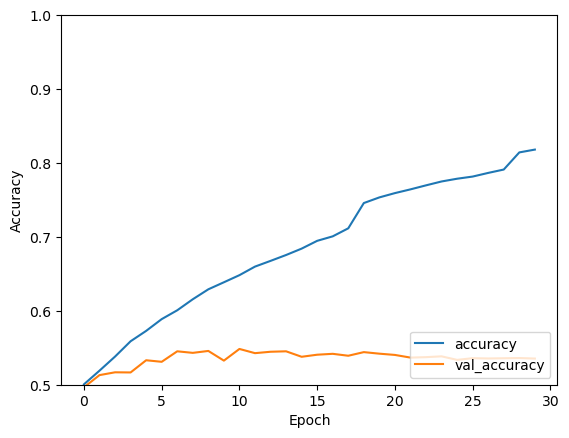

In [110]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

In [111]:
print("최종 정확도 : " + str( test_acc * 100 ) + " %" )

최종 정확도 : 53.53999733924866 %
